Smoothed NDVI

In [5]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from p_drought_indices.functions.ndvi_functions import get_irradiances, compute_ndvi_corr

CONFIG_PATH= "../config.yaml"

config_file = load_config(CONFIG_PATH=CONFIG_PATH)

ndvi_dir = config_file['NDVI']['ndvi_prep']
    
new_dir = os.path.join(ndvi_dir,"new_process")
list_files_2 = [os.path.join(new_dir, f) for f in os.listdir(new_dir) if f.endswith(".nc")]

ds = xr.open_dataset(list_files_2[1000])

msg_type = ds.attrs['EPCT_product_name'][:4]

girradiance_vis6, irradiance_vis8 = get_irradiances(msg_type)

'MSG2'

In [2]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

CONFIG_PATH= "../config.yaml"

config_file = load_config(CONFIG_PATH=CONFIG_PATH)

# Open the NetCDF file with xarray
ds = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'ndvi_no_out.nc'))
ds_ndvi = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_prep'], 'final_ndvi.nc'))
ds_smoot = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'smoothed_ndvi_1.nc'))
vci = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'vci_1D.nc'))

/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
2023-06-07 18:18:09.339458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xarray/core/indexes.py:200: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  indexer = index.slice_indexer(


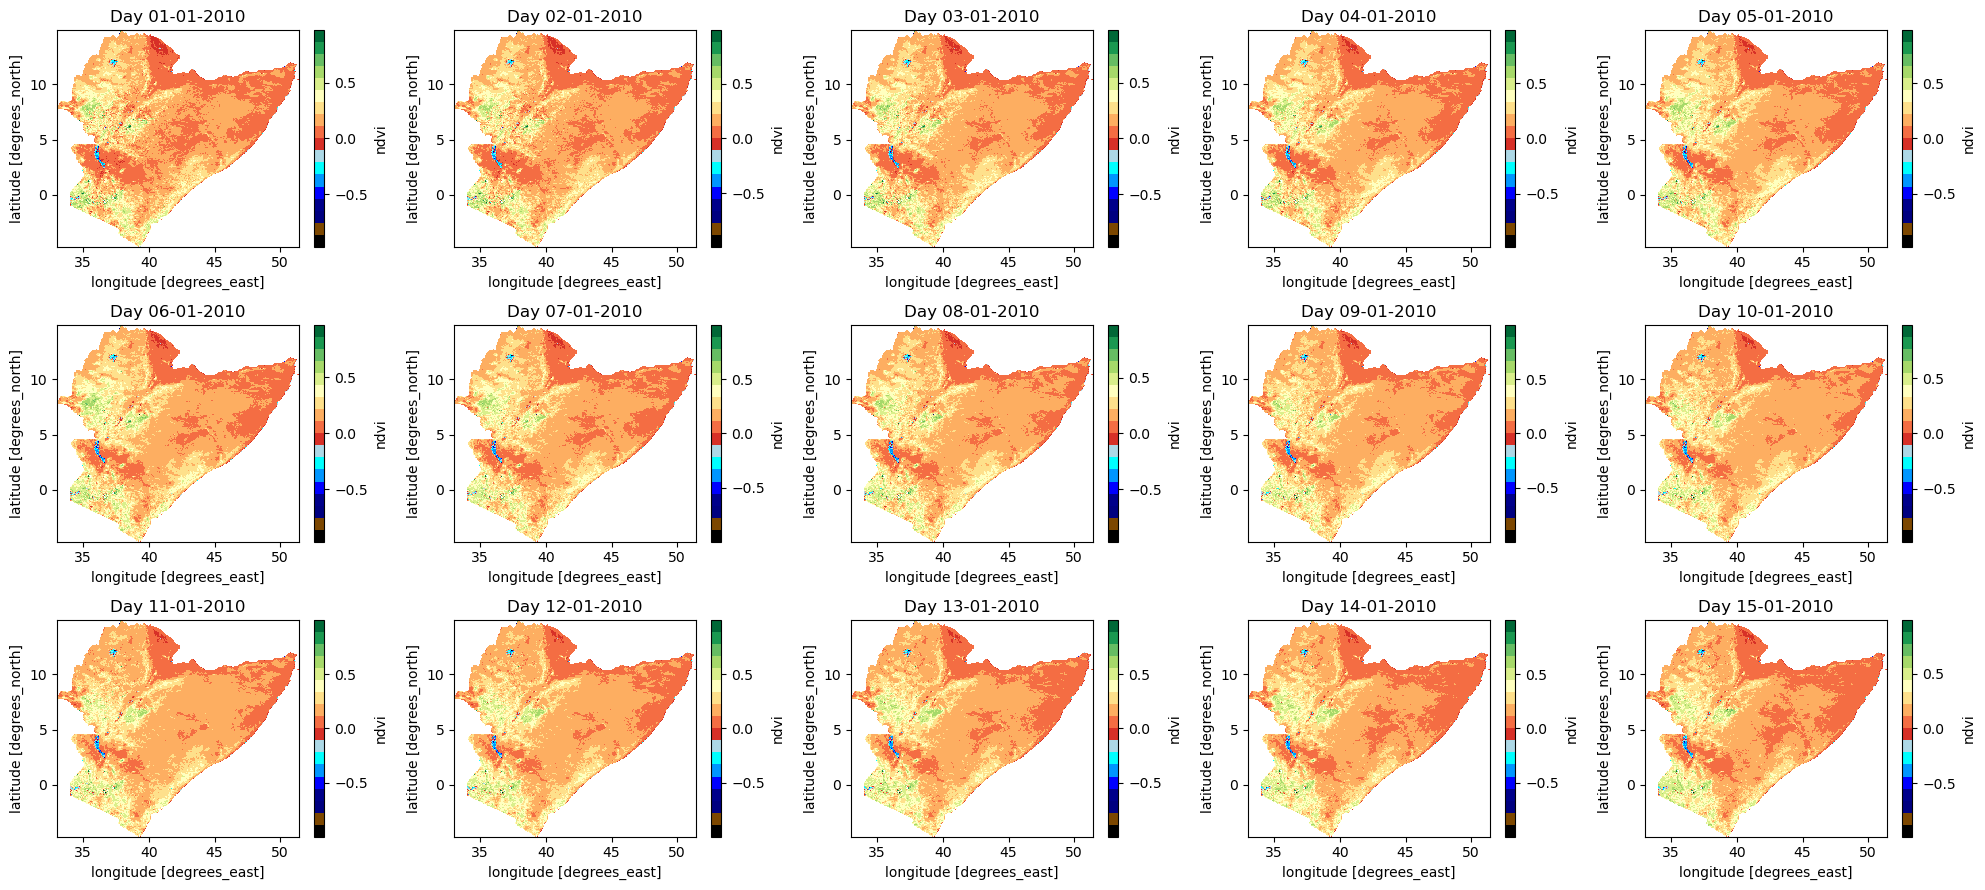

In [5]:
import pandas as pd 
from datetime import timedelta

from p_drought_indices.analysis.visualizations.viz_series import plot_ndvi_days

plot_ndvi_days(ds_smoot,
               start_day="2010-01-01",
                num_timesteps=15)

In [3]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing, get_lat_lon_window
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader

CONFIG_PATH= "../config.yaml"

config_file = load_config(CONFIG_PATH=CONFIG_PATH)

# Open the NetCDF file with xarray
dataset = prepare(xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'smoothed_ndvi_1.nc')))

time_end = "2019-12-31"
time_start = "2005-01-01"

prod = "ERA5"
late = 60

config_directories = [config_file['SPI']['IMERG']['path'], config_file['SPI']['GPCC']['path'], config_file['SPI']['CHIRPS']['path'], config_file['SPI']['ERA5']['path'], config_file['SPI']['MSWEP']['path'] ]
path = config_file['SPI']['ERA5']['path']
file = "ERA5_spi_gamma_60.nc"
precp_ds = xr.open_dataset(os.path.join(path, file))
var_target = "spi_gamma_{}".format(late)
print(f"The {prod} raster has spatial dimensions:", precp_ds.rio.resolution())


dim=32
idx_lat, lat_max, idx_lon, lon_min = get_lat_lon_window(precp_ds, dim)

sub_precp = prepare(precp_ds).sel(time=slice(time_start,time_end))\
    .sel(lat=slice(lat_max, idx_lat), lon=slice(lon_min, idx_lon))


ds = dataset["ndvi"].rio.reproject_match(sub_precp[var_target]).rename({'x':'lon','y':'lat'})

#config_dir_precp = [config_file['PRECIP']['IMERG']['path'],config_file['PRECIP']['CHIRPS_05']['path'], config_file['PRECIP']['GPCC']['path'], config_file['PRECIP']['CHIRPS']['path'], config_file['PRECIP']['ERA5']['path'],  config_file['PRECIP']['TAMSTAT']['path'],config_file['PRECIP']['MSWEP']['path']]
        

#product_dir = [f for f in config_dir_precp if prod in f][0]
#list_files = [f for f in os.listdir(product_dir) if (f.endswith(".nc")) and ("merged" in f)]
#precp_ds = xr.open_dataset(os.path.join(product_dir, list_files[0]))
#variable = [var for var in precp_ds.data_vars if var!= "spatial_ref"][0]


#sub_precp= precp_ds.isel(lat=slice(18,50)).sel( lon=slice(37,45)).sel(time=slice(time_start,time_end)).isel(lat=slice(0,dim), lon=slice(0,dim))


#### training parameters
train_split = 0.8
batch_size=4
preprocess_type="nearest"

train_data, test_data, train_label, test_label = CNN_preprocessing(ds, sub_precp, var_origin="ndvi", var_target=var_target, preprocess_type=preprocess_type,  split=train_split)

# create a CustomDataset object using the reshaped input data
train_dataset = CustomDataset(train_data, train_label)
test_dataset = CustomDataset(test_data, test_label)

# create a DataLoader object that uses the dataset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


### check shape of data

for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    inputs = inputs.float()
    targets = targets.float()
    print(inputs.shape, targets.shape, inputs.max(), inputs.min())


for batch_idx, (inputs, targets) in enumerate(test_dataloader):
    inputs = inputs.float()
    targets = targets.float()
    print(inputs.shape, targets.shape, inputs.max(), inputs.min())

The ERA5 raster has spatial dimensions: (0.25, -0.25)
Preprocessing data with nearest neighbor from scipy.interpolate.griddata
The input data has shape: (1, 5478, 1, 32, 32)


ValueError: cannot reshape array of size 5820416 into shape (32,32,5478,1)

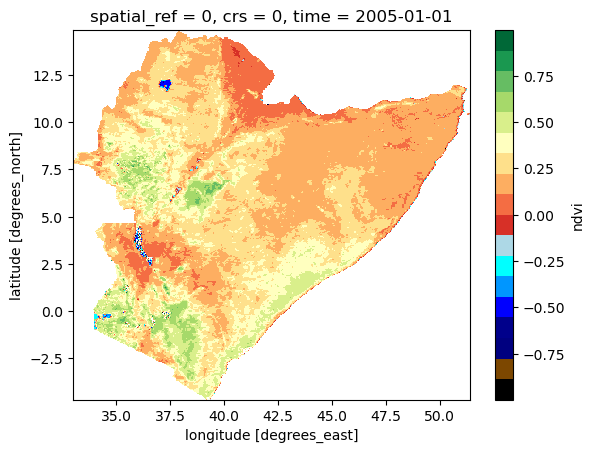

In [21]:
from p_drought_indices.analysis.visualizations.viz_series import ndvi_colormap

custom_map = ndvi_colormap()
ds.isel(time=0).plot(cmap=custom_map)

In [75]:
idx_lat, lat_max, idx_lon, lon_min = get_lat_lon_window(temp_ds, target_pixels)

In [78]:
ds = temp_ds.sel(lat=slice(idx_lat, lat_max), lon=slice(lon_min, idx_lon))

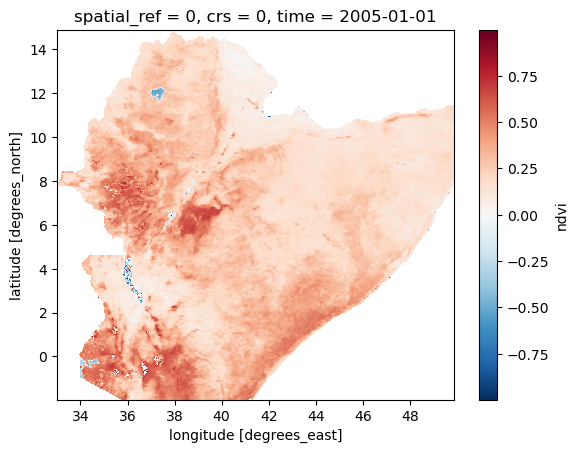

In [79]:
ds["ndvi"].isel(time=0).plot()

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn

class ConvLSTMBlock(nn.Module):
    def __init__(self, in_channels, num_features, kernel_size=3, padding=1, stride=1):
        super().__init__()
        self.num_features = num_features
        self.conv = self._make_layer(in_channels+num_features, num_features*4,
                                       kernel_size, padding, stride)

    def _make_layer(self, in_channels, out_channels, kernel_size, padding, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=kernel_size, padding=padding, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels))

    def forward(self, inputs):
        '''
        :param inputs: (B, S, C, H, W)
        :param hidden_state: (hx: (B, S, C, H, W), cx: (B, S, C, H, W))
        :return:
        '''
        outputs = []
        B, S, C, H, W = inputs.shape
        hx = torch.zeros(B, self.num_features, H, W).to(inputs.device)
        cx = torch.zeros(B, self.num_features, H, W).to(inputs.device)
        for t in range(S):
            combined = torch.cat([inputs[:, t], # (B, C, H, W)
                                  hx], dim=1)
            gates = self.conv(combined)
            ingate, forgetgate, cellgate, outgate = torch.split(gates, self.num_features, dim=1)
            ingate = torch.sigmoid(ingate)
            forgetgate = torch.sigmoid(forgetgate)
            outgate = torch.sigmoid(outgate)

            cy = (forgetgate * cx) + (ingate * cellgate)
            hy = outgate * torch.tanh(cy)
            outputs.append(hy)
            hx = hy
            cx = cy

        return torch.stack(outputs).permute(1, 0, 2, 3, 4).contiguous() # (S, B, C, H, W) -> (B, S, C, H, W)

class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = []
        for idx, params in enumerate(config.encoder):
            setattr(self, params[0]+'_'+str(idx), self._make_layer(*params))
            self.layers.append(params[0]+'_'+str(idx))

    def _make_layer(self, type, activation, in_ch, out_ch, kernel_size, padding, stride):
        layers = []
        if type == 'conv':
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride, bias=False))
            layers.append(nn.BatchNorm2d(out_ch))
            if activation == 'leaky': layers.append(nn.LeakyReLU(inplace=True))
            elif activation == 'relu': layers.append(nn.ReLU(inplace=True))
        elif type == 'convlstm':
            layers.append(ConvLSTMBlock(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride))
        return nn.Sequential(*layers)

    def forward(self, x):
        '''
        :param x: (B, S, C, H, W)
        :return:
        '''
        outputs = [x]
        for layer in self.layers:
            if 'conv_' in layer:
                B, S, C, H, W = x.shape
                x = x.view(B*S, C, H, W)
            x = getattr(self, layer)(x)
            if 'conv_' in layer: x = x.view(B, S, x.shape[1], x.shape[2], x.shape[3])
            if 'convlstm' in layer: outputs.append(x)
        return outputs

class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = []
        for idx, params in enumerate(config.decoder):
            setattr(self, params[0]+'_'+str(idx), self._make_layer(*params))
            self.layers.append(params[0]+'_'+str(idx))

    def _make_layer(self, type, activation, in_ch, out_ch, kernel_size, padding, stride):
        layers = []
        if type == 'conv':
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride, bias=False))
            layers.append(nn.BatchNorm2d(out_ch))
            if activation == 'leaky': layers.append(nn.LeakyReLU(inplace=True))
            elif activation == 'relu': layers.append(nn.ReLU(inplace=True))
            elif activation == 'sigmoid': layers.append(nn.Sigmoid())
        elif type == 'convlstm':
            layers.append(ConvLSTMBlock(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride))
        elif type == 'deconv':
            layers.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride, bias=False))
            layers.append(nn.BatchNorm2d(out_ch))
            if activation == 'leaky': layers.append(nn.LeakyReLU(inplace=True))
            elif activation == 'relu': layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, encoder_outputs):
        '''
        :param x: (B, S, C, H, W)
        :return:
        '''
        idx = len(encoder_outputs)-1
        for layer in self.layers:
            if 'conv_' in layer or 'deconv_' in layer:
                x = encoder_outputs[idx]
                B, S, C, H, W = x.shape
                x = x.view(B*S, C, H, W)
                x = getattr(self, layer)(x)
                x = x.view(B, S, x.shape[1], x.shape[2], x.shape[3])
            elif 'convlstm' in layer:
                idx -= 1
                x = torch.cat([encoder_outputs[idx], x], dim=2)
                x = getattr(self, layer)(x)
                encoder_outputs[idx] = x
        return x

class ConvLSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def train(config, logger, epoch, model, train_loader, criterion, optimizer):
    model.train()
    epoch_records = {'loss': []}
    num_batchs = len(train_loader)
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        print(inputs.max())
        inputs = inputs.float().to(config.device)
        targets = targets.float().to(config.device)
        outputs = model(inputs)
        losses = criterion(outputs, targets)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_records['loss'].append(losses.item())
        if batch_idx and batch_idx % config.display == 0:
            logger.info('EP:{:03d}\tBI:{:05d}/{:05d}\tLoss:{:.6f}({:.6f})'.format(epoch, batch_idx, num_batchs,
                                                                                epoch_records['loss'][-1], np.mean(epoch_records['loss'])))
    return epoch_records

def valid(config, logger, epoch, model, valid_loader, criterion):
    model.eval()
    epoch_records = {'loss': []}
    num_batchs = len(valid_loader)
    for batch_idx, (inputs, targets) in enumerate(valid_loader):
        with torch.no_grad():
            inputs = inputs.float().to(config.device)
            targets = targets.float().to(config.device)
            outputs = model(inputs)
            losses = criterion(outputs, targets)
            epoch_records['loss'].append(losses.item())
            if batch_idx and batch_idx % config.display == 0:
                logger.info('[V] EP:{:03d}\tBI:{:05d}/{:05d}\tLoss:{:.6f}({:.6f})'.format(epoch, batch_idx, num_batchs,
                                                                                    epoch_records['loss'][-1], np.mean(epoch_records['loss'])))
    return epoch_records

import logging
import os
import time

def build_logging(config):
    logging.basicConfig(level=logging.DEBUG,
                        format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                        datefmt='%m-%d %H:%M',
                        filename=os.path.join(config.log_dir, time.strftime("%Y%d%m_%H%M") + '.log'),
                        filemode='w')
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')
    console.setFormatter(formatter)
    logging.getLogger('').addHandler(console)
    return logging

In [8]:
from p_drought_indices.configs.config_3x3_16_3x3_32_3x3_64 import config
from torch.nn import MSELoss
import matplotlib.pyplot as plt

name = '3x3_16_3x3_32_3x3_64'

logger = build_logging(config)
model = ConvLSTM(config).to(config.device)
#criterion = CrossEntropyLoss().to(config.device)
#criterion = torch.nn.MSELoss().to(config.device)
criterion = MSELoss().to(config.device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_records, valid_records, test_records = [], [], []
for epoch in range(config.epochs):
    epoch_records = train(config, logger, epoch, model, train_dataloader, criterion, optimizer)
    train_records.append(np.mean(epoch_records['loss']))
    epoch_records = valid(config, logger, epoch, model, test_dataloader, criterion)
    valid_records.append(np.mean(epoch_records['loss']))
    plt.plot(range(epoch + 1), train_records, label='train')
    plt.plot(range(epoch + 1), valid_records, label='valid')
    plt.legend()
    plt.savefig(os.path.join(config.output_dir, '{m}_{n}.png'.format(n=name, m=preprocess_type)))
    plt.close()

/media/BIFROST/N2/Riccardo/Indices_analysis/notebooks/.
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3.0900, dtype=torch.float64)
tensor(3